# Uçtan Büyük Veride Makine Öğrenmesi

Müşterilerimiz bizi terk eder mi ?

## Spark Session ve Veri Seti

In [1]:
import findspark
findspark.init("/Users/alperencngzz/Documents/spark/spark-3.3.0-bin-hadoop3")
import pyspark
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark import SparkContext

spark = SparkSession.builder \
    .master("local") \
    .appName("churn_modellemesi") \
    .config("spark.executer.memory", "16gb") \
    .getOrCreate()



sc = spark.sparkContext
sc

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/28 09:31:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/09/28 09:31:02 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


<SparkContext master=local appName=churn_modellemesi>

In [2]:
spark_df = spark.read.csv("churn.csv", 
                          header = True, 
                          inferSchema = True,
                          sep = ",")
spark_df.cache()

DataFrame[_c0: int, Names: string, Age: double, Total_Purchase: double, Account_Manager: int, Years: double, Num_Sites: double, Churn: int]

In [3]:
spark_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Churn: integer (nullable = true)



In [4]:
spark_df.show(5)

22/09/28 09:31:10 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
 Schema: _c0, Names, Age, Total_Purchase, Account_Manager, Years, Num_Sites, Churn
Expected: _c0 but found: 
CSV file: file:///Users/alperencngzz/VBO%20Machine%20Learning/Benim%20kodlarım/14_ML_BigData_Analytics/churn.csv


+---+----------------+----+--------------+---------------+-----+---------+-----+
|_c0|           Names| Age|Total_Purchase|Account_Manager|Years|Num_Sites|Churn|
+---+----------------+----+--------------+---------------+-----+---------+-----+
|  0|Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|    1|
|  1|   Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|    1|
|  2|     Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|    1|
|  3|   Phillip White|42.0|       8010.76|              0| 6.71|     10.0|    1|
|  4|  Cynthia Norton|37.0|       9191.58|              0| 5.56|      9.0|    1|
+---+----------------+----+--------------+---------------+-----+---------+-----+
only showing top 5 rows



Öncelikle bütün değişkenlerin ismini küçük harfe ya da büyük harfe çevirelim ve verinin index ismi olan _c0'dan kurtulalım. 

#### Dönüştürme işlemini benim yapış

In [5]:
#columns = []
#for i in spark_df.columns:
#    col = i.lower()
#    columns.append(col)

#print(columns)

In [6]:
#spark_df = spark_df.toDF(*columns)

In [7]:
#spark_df.show(3)

#### ------

In [8]:
# derste yapılan (tek satırda mis gibi)
spark_df = spark_df.toDF(*[c.lower() for c in spark_df.columns])

In [9]:
spark_df.show(3)

+---+----------------+----+--------------+---------------+-----+---------+-----+
|_c0|           names| age|total_purchase|account_manager|years|num_sites|churn|
+---+----------------+----+--------------+---------------+-----+---------+-----+
|  0|Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|    1|
|  1|   Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|    1|
|  2|     Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|    1|
+---+----------------+----+--------------+---------------+-----+---------+-----+
only showing top 3 rows



In [10]:
# pandas ile çalışırken aynı işlemi yapmak istersek:
# df.columns = map(str.lower, df.columns)

In [11]:
spark_df = spark_df.withColumnRenamed("_c0", "index")

In [12]:
spark_df.show(3)

+-----+----------------+----+--------------+---------------+-----+---------+-----+
|index|           names| age|total_purchase|account_manager|years|num_sites|churn|
+-----+----------------+----+--------------+---------------+-----+---------+-----+
|    0|Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|    1|
|    1|   Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|    1|
|    2|     Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|    1|
+-----+----------------+----+--------------+---------------+-----+---------+-----+
only showing top 3 rows



In [13]:
spark_df.count()

900

In [14]:
len(spark_df.columns)

8

In [15]:
spark_df.columns

['index',
 'names',
 'age',
 'total_purchase',
 'account_manager',
 'years',
 'num_sites',
 'churn']

In [16]:
# verisetimize bakınca her gözlemin unique olması gerekiyor çünkü hepsi farklı insanlardan oluşuyor, bunu kontrol edelim:

In [17]:
spark_df.distinct().count() # spark_df.count() ile aynı, büyük ihtimal unique

900

In [18]:
spark_df.select("names").distinct().count() # burada 2 tane aynı isimli gözlem olduğunu gördük

899

In [19]:
# bu aynı isimli gözlemler bir çoklama hatası mı yoksa sadece aynı isimli müşterileri mi?:

In [20]:
spark_df.groupby("names").count().sort("count", ascending = False).show(3)

+-------------+-----+
|        names|count|
+-------------+-----+
|Jennifer Wood|    2|
| Patrick Bell|    1|
|Chelsea Marsh|    1|
+-------------+-----+
only showing top 3 rows



In [21]:
# 2 tane jennifer wood var, ama hala çoklama olduğundan emin olamayız:

In [22]:
spark_df.filter(spark_df.names == "Jennifer Wood").show()

+-----+-------------+----+--------------+---------------+-----+---------+-----+
|index|        names| age|total_purchase|account_manager|years|num_sites|churn|
+-----+-------------+----+--------------+---------------+-----+---------+-----+
|   22|Jennifer Wood|35.0|       9381.12|              1| 6.78|     11.0|    1|
|  439|Jennifer Wood|48.0|      11585.16|              0| 4.61|      9.0|    0|
+-----+-------------+----+--------------+---------------+-----+---------+-----+



In [23]:
# gördüğümüz gibi aynı isim ama farklı bilgiler o yüzden bir çoklama problemimiz yok

#### ya bu gözlem duplicate kayıt olsaydı?

In [24]:
# Belirli bir değişken üzerindeki duplicate kayıtları silmek istersek:

In [25]:
spark_df.select("names").dropDuplicates().groupby("names").count().sort("count", ascending = False).show(3)

+----------------+-----+
|           names|count|
+----------------+-----+
|    Patrick Bell|    1|
|Patrick Robinson|    1|
|   Chelsea Marsh|    1|
+----------------+-----+
only showing top 3 rows



In [26]:
# Bu kodda normalde spark_df.select("names").dropDuplicates() kısmı silme işlemi için yeterli
# .groupby("names").count().sort("count", ascending = False).show(3) kısmı ise doğru şeyi sildiğimizi kontrol etmek için
# Bir üstteki kodda jennifer'lardan birini hala bırakacak çünkü duplicate de olsa 1 tane öyle gözlem var

Sonuç olarak:
1. Duplicate kayıtlar mutlaka incelenmeli, gözlemlerimiz kurumlar, bireyler gibi nadide gözlem birimleri olduğunda veri setinin veri tabanından alındıktan sonra bir kontrolü gereklidir.

#### ------

In [27]:
# herhangi bir indexe erişmemiz gerekirse:

In [28]:
spark_df.where(spark_df.index == 439).select("names").show()

+-------------+
|        names|
+-------------+
|Jennifer Wood|
+-------------+



In [29]:
spark_df.where(spark_df.index == 439).show()

+-----+-------------+----+--------------+---------------+-----+---------+-----+
|index|        names| age|total_purchase|account_manager|years|num_sites|churn|
+-----+-------------+----+--------------+---------------+-----+---------+-----+
|  439|Jennifer Wood|48.0|      11585.16|              0| 4.61|      9.0|    0|
+-----+-------------+----+--------------+---------------+-----+---------+-----+



In [30]:
# özellikle names (herhangi bir columndan bir değer) değeri üzerinden gözleme erişmek VE bunu girdi olarak kullanmak:

In [31]:
spark_df.where(spark_df.index == 439).collect()[0]["names"]

'Jennifer Wood'

In [32]:
jen = spark_df.where(spark_df.index == 439).collect()[0]["names"]

In [33]:
type(jen)

str

In [34]:
jen.upper()

'JENNIFER WOOD'

In [35]:
# toPandas ve collect fonksiyonları veriyi spark'dan localimize alabilmek için kulalndığımız fonksiyonlar.

#### Kendi kendime bir şeyler deneme

In [36]:
#Görev: En çok harcayanları bulup dataframe'e çevirmek

In [37]:
spark_df.where(spark_df.total_purchase > 15000).show()

+-----+------------------+----+--------------+---------------+-----+---------+-----+
|index|             names| age|total_purchase|account_manager|years|num_sites|churn|
+-----+------------------+----+--------------+---------------+-----+---------+-----+
|   41|    Jason Jones MD|55.0|      16838.94|              1| 6.66|      8.0|    1|
|  128|    Monique Medina|49.0|      15005.43|              1| 5.27|     12.0|    1|
|  150|  Michael Williams|35.0|      15571.26|              0| 6.45|      9.0|    0|
|  244|       Erin Norris|37.0|      15070.32|              0| 6.91|      6.0|    0|
|  342|   Darin Alexander|43.0|      15858.91|              1| 4.51|      8.0|    0|
|  354|     Kenneth James|41.0|      15516.52|              0| 3.53|     10.0|    0|
|  357|      Katie Wagner|43.0|      15423.03|              1| 2.41|      7.0|    0|
|  467|      Holly Flores|47.0|      15878.11|              1| 2.05|      8.0|    0|
|  661|    Brandon Hunter|45.0|      15188.65|              0| 6.

In [38]:
best_spenders = spark_df.where(spark_df.total_purchase > 15000).collect()

In [39]:
 best_spenders

[Row(index=41, names='Jason Jones MD', age=55.0, total_purchase=16838.94, account_manager=1, years=6.66, num_sites=8.0, churn=1),
 Row(index=128, names='Monique Medina', age=49.0, total_purchase=15005.43, account_manager=1, years=5.27, num_sites=12.0, churn=1),
 Row(index=150, names='Michael Williams', age=35.0, total_purchase=15571.26, account_manager=0, years=6.45, num_sites=9.0, churn=0),
 Row(index=244, names='Erin Norris', age=37.0, total_purchase=15070.32, account_manager=0, years=6.91, num_sites=6.0, churn=0),
 Row(index=342, names='Darin Alexander', age=43.0, total_purchase=15858.91, account_manager=1, years=4.51, num_sites=8.0, churn=0),
 Row(index=354, names='Kenneth James', age=41.0, total_purchase=15516.52, account_manager=0, years=3.53, num_sites=10.0, churn=0),
 Row(index=357, names='Katie Wagner', age=43.0, total_purchase=15423.03, account_manager=1, years=2.41, num_sites=7.0, churn=0),
 Row(index=467, names='Holly Flores', age=47.0, total_purchase=15878.11, account_mana

In [40]:
ages_of_bests = 0
bestc = 0
for i in best_spenders:
    ages_of_bests += i[5]
    bestc += 1
    
print(ages_of_bests / bestc)

4.869999999999999


#### ------

## Keşifçi Veri Analizi

In [41]:
spark_df.describe().show()

+-------+------------------+-------------+-----------------+-----------------+------------------+-----------------+------------------+-------------------+
|summary|             index|        names|              age|   total_purchase|   account_manager|            years|         num_sites|              churn|
+-------+------------------+-------------+-----------------+-----------------+------------------+-----------------+------------------+-------------------+
|  count|               900|          900|              900|              900|               900|              900|               900|                900|
|   mean|             449.5|         null|41.81666666666667|10062.82403333334|0.4811111111111111| 5.27315555555555| 8.587777777777777|0.16666666666666666|
| stddev|259.95191863111916|         null|6.127560416916251|2408.644531858096|0.4999208935073339|1.274449013194616|1.7648355920350969| 0.3728852122772358|
|    min|                 0|   Aaron King|             22.0|          

In [42]:
# çıktıyı daha düzgün bir şekile getirmek istersek:

In [43]:
spark_df.select("age","total_purchase", "account_manager", "years","num_sites","churn").describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,900,41.81666666666667,6.127560416916251,22.0,65.0
total_purchase,900,10062.82403333334,2408.644531858096,100.0,18026.01
account_manager,900,0.4811111111111111,0.4999208935073339,0,1
years,900,5.27315555555555,1.274449013194616,1.0,9.15
num_sites,900,8.587777777777777,1.7648355920350969,3.0,14.0
churn,900,0.16666666666666666,0.3728852122772358,0,1


Veri incelemesindeki önemli noktalardan biri churn değişkeninin ortalamasının 0.166 çıkması:
1. churn bir kategorik değişken olduğu için 0 ve 1 alıyor
2. 0'lar çok daha fazla olduğu için ortalaması 0.16 oluyor
3. makine öğrenmesinde train test split yaparken dengesiz veri olduğunu göz önünde bulundurarak modelimizi kurmamız gerekiyor.

In [44]:
spark_df.filter(spark_df.age > 47).count()

161

In [45]:
# burada ortalama + stddev toplayıp onun üstünde kalan gözlem birimlerinin sayısına baktık, veri tanıma amaçlı bir işlem

In [46]:
spark_df.filter(spark_df.age < 36).count()

132

In [47]:
spark_df.groupby("churn").count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|  150|
|    0|  750|
+-----+-----+



In [48]:
# şimdi asıl işimize yarayacak kısımlardan biri olan değişkenler arasında çaprazlamalar yapacağız
# burada önemli olan veriyi iyice anlamak, dersteki not dinlenebilir (401)

In [49]:
spark_df.groupby("churn").agg({"total_purchase": "mean"}).show()
# görüyoruz ki total purchase çok da etkilemiyor churn'ü

+-----+-------------------+
|churn|avg(total_purchase)|
+-----+-------------------+
|    1| 10192.179933333337|
|    0| 10036.952853333332|
+-----+-------------------+



In [50]:
spark_df.groupby("churn").agg({"years": "mean"}).show()
# yıl bir miktar daha etkiliyor gibi

+-----+------------------+
|churn|        avg(years)|
+-----+------------------+
|    1|5.8835999999999995|
|    0|5.1510666666666625|
+-----+------------------+



### şimdi bir korelasyon matrisi oluşturmak istersek:

In [51]:
kor_data = spark_df.drop("index", "names").toPandas()

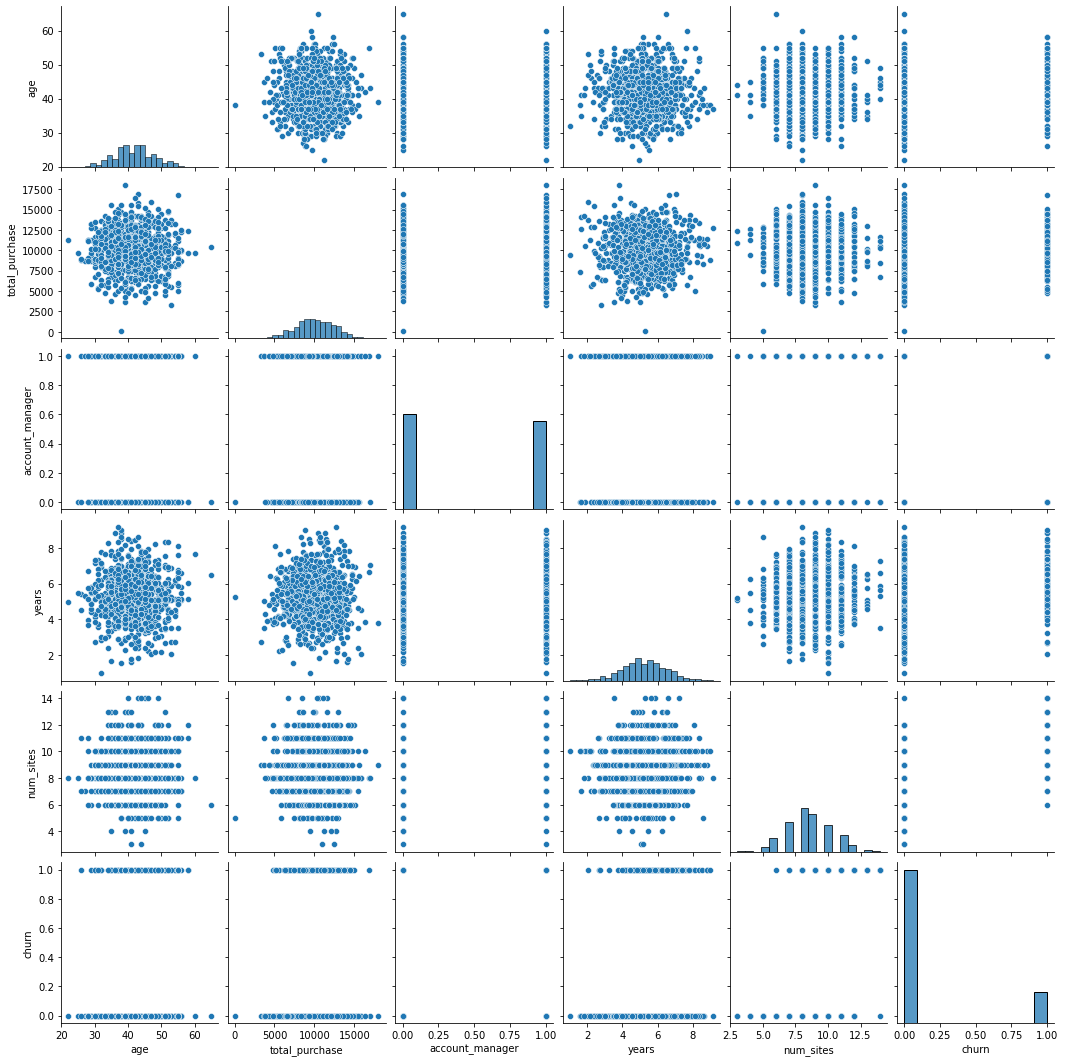

In [52]:
import seaborn as sns
sns.pairplot(kor_data);

In [53]:
# değişkenler arasındaki korelasyonel anlamda pek de bir ilişki görünmüyor, kategorik değişkenlerde zaten pek bir şey olmaz

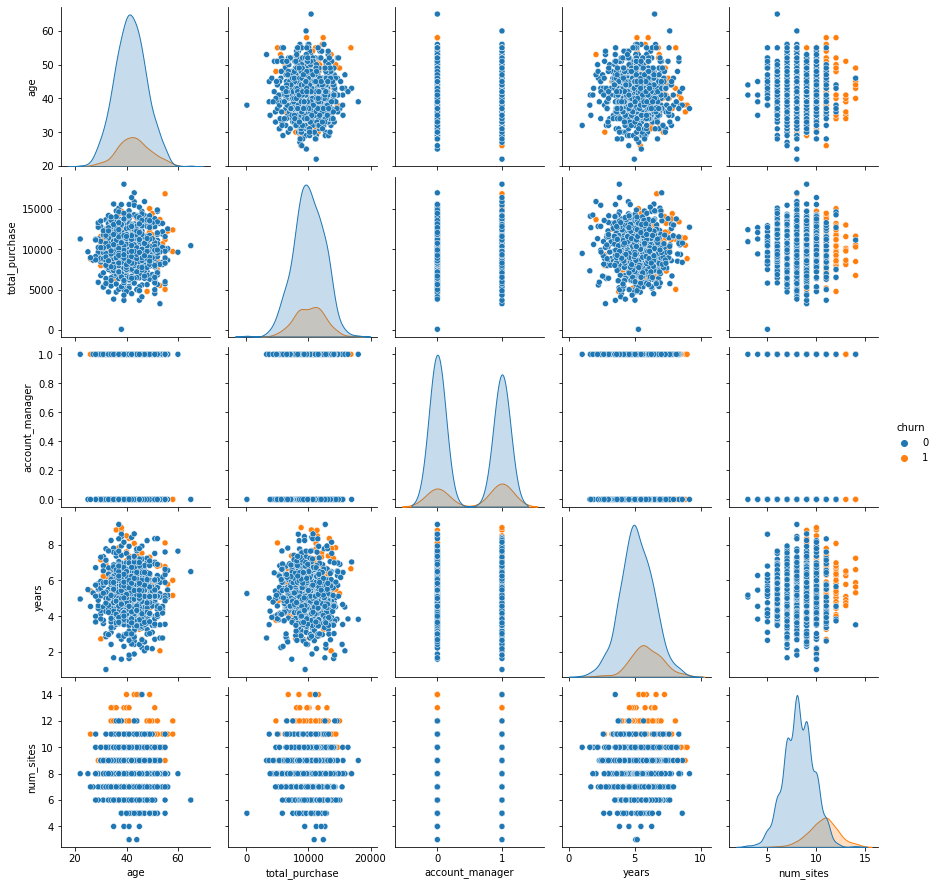

In [54]:
sns.pairplot(kor_data, hue = "churn");

In [55]:
# burada şimdi churn değişkenini grafiklere boyut olarak eklemeye çalışacağız

/Users/alperencngzz/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


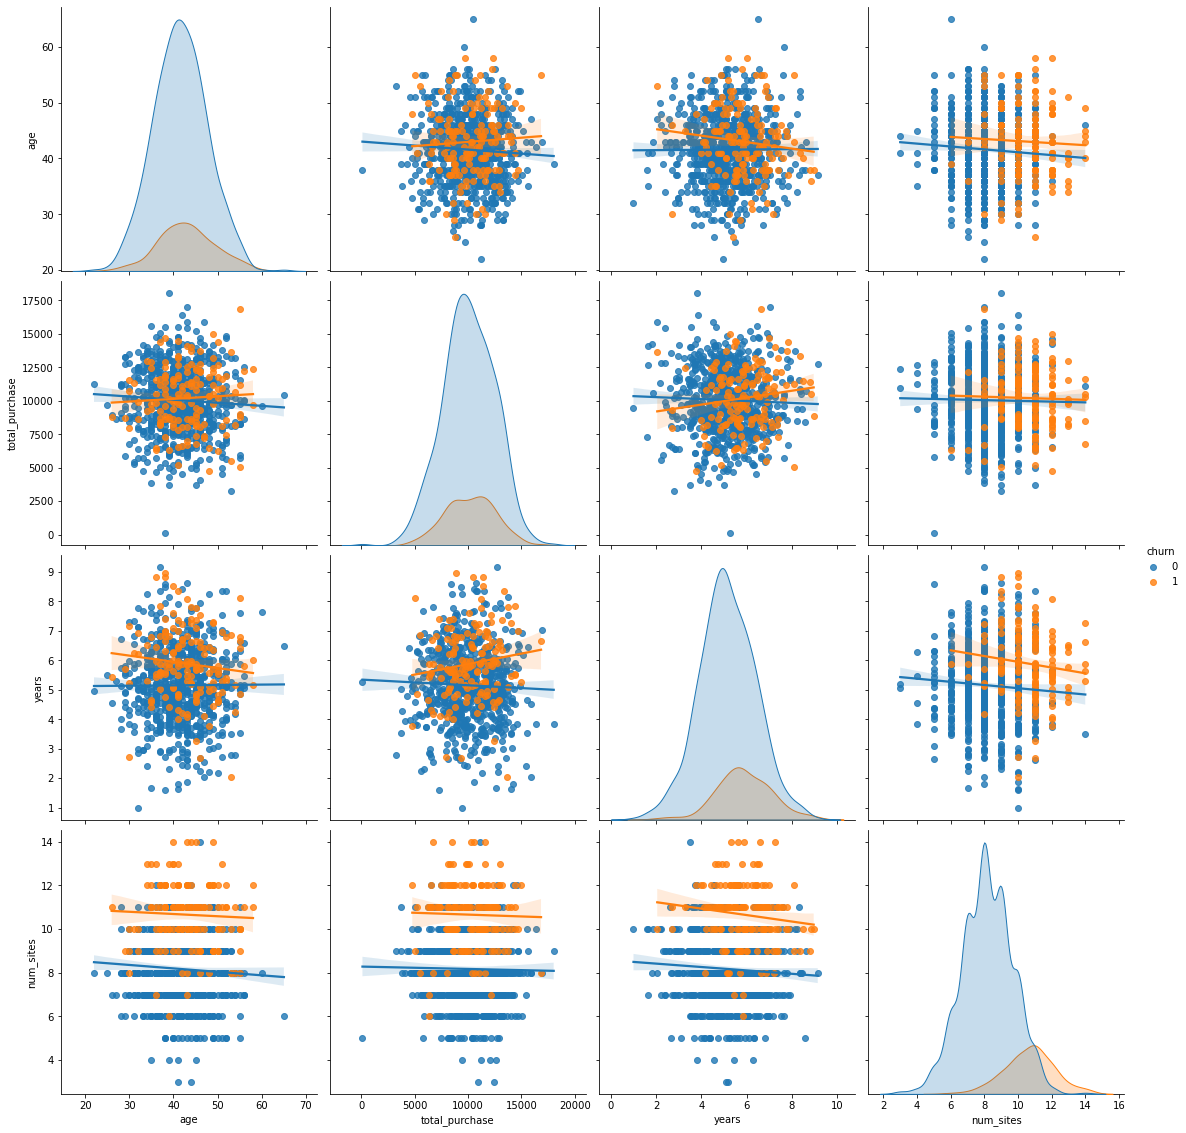

In [81]:
sns.pairplot(kor_data, vars = ["age", "total_purchase","years","num_sites"], 
             hue = "churn",
            kind = "reg",
            size = 4);

Son yaptığımız pairplot işleminde churn'un bazı yerlerde 0 ve 1 gruplarının farklı korelasyonlar oluşturma eğiliminde olduğunu gördük. Ama yine de çok net bilgiler alamadık

Kendim de biraz uğraşsam güzel olabilir

## Veri Ön İşleme

In [57]:
spark_df = spark_df.dropna() # eksik gözlemler gitti

In [58]:
# yeni bir değişken eklemek istersek
spark_df = spark_df.withColumn("age_square", spark_df.age **2)

In [59]:
spark_df.show(3)

+-----+----------------+----+--------------+---------------+-----+---------+-----+----------+
|index|           names| age|total_purchase|account_manager|years|num_sites|churn|age_square|
+-----+----------------+----+--------------+---------------+-----+---------+-----+----------+
|    0|Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|    1|    1764.0|
|    1|   Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|    1|    1681.0|
|    2|     Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|    1|    1444.0|
+-----+----------------+----+--------------+---------------+-----+---------+-----+----------+
only showing top 3 rows



Feature Engineering dediğimiz değişken oluşturma, yeni değişken ekleme, çaprazlama, yeni fikirlerde bulunma ve benzeri birçok işlem bu noktada yapılıyor. Aynı şekilde önceki bölümdeki korelasyon incelemelerine göre değişken seçilmelerine karar verilebilir. 

Ama bu kısım kurs içeriği olmaktan çıkıp 6 aylık bir çalışma sürecine girmektedir. Ama kod bazında temel olarak işlemler burada mevcut

### Bağımlı ve bağımsız değişkenleri ayarlamak gibi bir işlem yapmamız gerekiyor:

Büyük veri dünyasında fonksiyonların bizden beklediği belirli formatlar var

Büyük veri dünyası alışık olduğumuz şekilde R veya Pythonda çalıştığımız esneklikte çalışma imkanları bize sunamayabiliyor.

*Burada mümkün olduğu kadar low level bir etkileşimimiz oluyor ve bu low level etkileşimi standartlaştırmak gibi bazı ihtiyaçlar olduğundan bağımlı ve bağımsız değişkenleri belli bir STANDARTTA bir araya getirip (oluşturup) bizden bağımlı ve bağımsız değişkenleri isteyen ML fonkisyonlarına bu şekilde göndereceğiz.*

#### Bağımlı Değişkenin Ayarlanması

Şuan kurstaki bağımlı değişkenimiz string değil ama öyle muamele yapacağız çünkü gerçek hayatta büyük ihtimal o şekilde olacak, bizim şuan elimizdeki veride modellemeye hazır (numerik)

In [60]:
from pyspark.ml.feature import StringIndexer

In [61]:
stringIndexer = StringIndexer(inputCol = "churn", outputCol = "label") # bağımlı değişkenlere label, bağımsız değişkenlere features diyeceğiz outputCol'da
# burada StringIndexer kendisine girmiş olduğumuz verisetinde churn'u yakalayıp label olarak dönüştürme işlemine sokacak

In [62]:
# burada "By default, this is ordered by label frequenciesso the most frequent label gets index 0." ifadesi önemli
?stringIndexer

Type:           StringIndexer
String form:    StringIndexer_12739299c28c
File:           ~/Documents/spark/spark-3.3.0-bin-hadoop3/python/pyspark/ml/feature.py
Docstring:     
A label indexer that maps a string column of labels to an ML column of label indices.
If the input column is numeric, we cast it to string and index the string values.
The indices are in [0, numLabels). By default, this is ordered by label frequencies
so the most frequent label gets index 0. The ordering behavior is controlled by
setting :py:attr:`stringOrderType`. Its default value is 'frequencyDesc'.

.. versionadded:: 1.4.0

Examples
--------
>>> stringIndexer = StringIndexer(inputCol="label", outputCol="indexed",
...     stringOrderType="frequencyDesc")
>>> stringIndexer.setHandleInvalid("error")
StringIndexer...
>>> model = stringIndexer.fit(stringIndDf)
>>> model.setHandleInvalid("error")
StringIndexerModel...
>>> td = model.transform(stringIndDf)
>>> sorted(set([(i[0], i[1]) for i in td.select(td.id, td.in

In [63]:
indexed = stringIndexer.fit(spark_df).transform(spark_df)

In [64]:
indexed.dtypes

[('index', 'int'),
 ('names', 'string'),
 ('age', 'double'),
 ('total_purchase', 'double'),
 ('account_manager', 'int'),
 ('years', 'double'),
 ('num_sites', 'double'),
 ('churn', 'int'),
 ('age_square', 'double'),
 ('label', 'double')]

In [65]:
# burada label'i double'dan int'e çevireceğiz

In [66]:
spark_df = indexed.withColumn("label", indexed["label"].cast("integer"))

In [67]:
spark_df.dtypes

[('index', 'int'),
 ('names', 'string'),
 ('age', 'double'),
 ('total_purchase', 'double'),
 ('account_manager', 'int'),
 ('years', 'double'),
 ('num_sites', 'double'),
 ('churn', 'int'),
 ('age_square', 'double'),
 ('label', 'int')]

#### Bağımsız Değişkenin Ayarlanması

In [68]:
from pyspark.ml.feature import VectorAssembler

In [69]:
spark_df.columns

['index',
 'names',
 'age',
 'total_purchase',
 'account_manager',
 'years',
 'num_sites',
 'churn',
 'age_square',
 'label']

In [70]:
bag = ["age", "total_purchase", "account_manager", "years", "num_sites"]

In [71]:
# şimdi bağımsız değişkenlerden VectorAssembler fonksiyonu ile bir vektör oluşturacağız

In [72]:
vectorAssembler = VectorAssembler(inputCols = bag, outputCol = "features")

In [73]:
va_df = vectorAssembler.transform(spark_df)

In [74]:
# şuan hem bağımsız değişkenler hem de onları vektörleri elimizde var

#### Son olarak bağımlı ve bağımsız değişkenleri bir araya getirip final df'i oluşturacağız

In [75]:
final_df = va_df.select(["features", "label"])

In [76]:
final_df.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[42.0,11066.8,0.0...|    1|
|[41.0,11916.22,0....|    1|
|[38.0,12884.75,0....|    1|
|[42.0,8010.76,0.0...|    1|
|[37.0,9191.58,0.0...|    1|
|[48.0,10356.02,0....|    1|
|[44.0,11331.58,1....|    1|
|[32.0,9885.12,1.0...|    1|
|[43.0,14062.6,1.0...|    1|
|[40.0,8066.94,1.0...|    1|
|[30.0,11575.37,1....|    1|
|[45.0,8771.02,1.0...|    1|
|[45.0,8988.67,1.0...|    1|
|[40.0,8283.32,1.0...|    1|
|[41.0,6569.87,1.0...|    1|
|[38.0,10494.82,1....|    1|
|[45.0,8213.41,1.0...|    1|
|[43.0,11226.88,0....|    1|
|[53.0,5515.09,0.0...|    1|
|[46.0,8046.4,1.0,...|    1|
+--------------------+-----+
only showing top 20 rows



pyspark'ın bizden beklediği bağzı ml fonksiyonlarının sabit bir yapısı var (features ve label yapısı). Dolayısıyla elimize bir veriseti geldiğinde bu verisetinin bağımlı ve bağımsız değişkenlerini bu formata getirmek bize koaylık sağlar.

## Test-Train Split

In [77]:
splits = final_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [78]:
train_df

DataFrame[features: vector, label: int]

In [79]:
test_df

DataFrame[features: vector, label: int]

## GBM ile Müşteri Terk Modellemesi

In [82]:
from pyspark.ml.classification import GBTClassifier

In [96]:
gbm = GBTClassifier(maxIter = 10, featuresCol = "features", labelCol = "label")

In [97]:
gbm_model = gbm.fit(train_df)

In [98]:
y_pred = gbm_model.transform(test_df)

In [99]:
y_pred

DataFrame[features: vector, label: int, rawPrediction: vector, probability: vector, prediction: double]

In [100]:
ac = y_pred.select("label","prediction")

In [101]:
ac.filter(ac.label == ac.prediction).count() / ac.count() # accuracy değerine erişmiş olduk (ilkel test hatası)

0.8374558303886925

## Model Tuning

In [89]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

evaluator = BinaryClassificationEvaluator()

paramGrid = (ParamGridBuilder()
             .addGrid(gbm.maxDepth, [2, 4, 6])
             .addGrid(gbm.maxBins, [20, 30])
             .addGrid(gbm.maxIter, [10, 20])
             .build())

cv = CrossValidator(estimator= gbm, estimatorParamMaps = paramGrid, evaluator=evaluator, numFolds= 10)

In [90]:
cv_model = cv.fit(train_df)

In [102]:
y_pred = cv_model.transform(test_df)
ac = y_pred.select("label","prediction")

In [103]:
ac.filter(ac.label == ac.prediction).count() / ac.count()

0.8515901060070671

In [104]:
evaluator.evaluate(y_pred)

0.871027721433401

In [105]:
# Bu kısıma kadar veri işleme, model kurma kısımları halloldu, şimdi yeni müşterilere tahmin yapma vakti

## Yeni Müşteriler Bizi Terk Eder mi ?

In [106]:
import pandas as pd
names = pd.Series(["Ali Ahmetoğlu", "Berkcan Tanerbey", "Harika Gündüz","Polat Alemdar", "Ata Bakmayan Ali"])
age = pd.Series([38, 43, 34, 50, 40])
total_purchase = pd.Series([30000, 10000, 6000, 30000, 100000])
account_manager = pd.Series([1,0,0,1,1])
years = pd.Series([20, 10, 3, 8, 30])
num_sites = pd.Series([30,8,8,6,50])


yeni_musteriler = pd.DataFrame({
    'names':names,
    'age': age,
    'total_purchase': total_purchase,
    'account_manager': account_manager ,
    'years': years,
    'num_sites': num_sites})

yeni_musteriler.columns

Index(['names', 'age', 'total_purchase', 'account_manager', 'years',
       'num_sites'],
      dtype='object')

In [107]:
yeni_musteriler

,names,age,total_purchase,account_manager,years,num_sites
0,Ali Ahmetoğlu,38,30000,1,20,30
1,Berkcan Tanerbey,43,10000,0,10,8
2,Harika Gündüz,34,6000,0,3,8
3,Polat Alemdar,50,30000,1,8,6
4,Ata Bakmayan Ali,40,100000,1,30,50


In [108]:
yeni_sdf = spark.createDataFrame(yeni_musteriler)

In [109]:
type(yeni_sdf)

pyspark.sql.dataframe.DataFrame

In [110]:
yeni_sdf.show()

+----------------+---+--------------+---------------+-----+---------+
|           names|age|total_purchase|account_manager|years|num_sites|
+----------------+---+--------------+---------------+-----+---------+
|   Ali Ahmetoğlu| 38|         30000|              1|   20|       30|
|Berkcan Tanerbey| 43|         10000|              0|   10|        8|
|   Harika Gündüz| 34|          6000|              0|    3|        8|
|   Polat Alemdar| 50|         30000|              1|    8|        6|
|Ata Bakmayan Ali| 40|        100000|              1|   30|       50|
+----------------+---+--------------+---------------+-----+---------+



In [111]:
yeni_musteriler = vectorAssembler.transform(yeni_sdf)

In [112]:
sonuclar = cv_model.transform(yeni_musteriler)

In [113]:
sonuclar.select("names","prediction").show()

+----------------+----------+
|           names|prediction|
+----------------+----------+
|   Ali Ahmetoğlu|       1.0|
|Berkcan Tanerbey|       0.0|
|   Harika Gündüz|       0.0|
|   Polat Alemdar|       0.0|
|Ata Bakmayan Ali|       1.0|
+----------------+----------+



## Diğer Bazı Modeller

In [114]:
from pyspark.ml.classification import LogisticRegression
loj = LogisticRegression(featuresCol = "features", labelCol = 'label', maxIter=10)
loj_model = loj.fit(train_df)
y_pred = loj_model.transform(test_df)
ac = y_pred.select("label", "prediction")
ac.filter(ac.label == ac.prediction).count() / ac.count()

0.8869257950530035

In [115]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dt_model = dt.fit(train_df)
y_pred = dt_model.transform(test_df)
ac = y_pred.select("label", "prediction")
ac.filter(ac.label == ac.prediction).count() / ac.count()

0.8621908127208481

In [116]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rf_model = rf.fit(train_df)
y_pred = rf_model.transform(test_df)
ac = y_pred.select("label", "prediction")
ac.filter(ac.label == ac.prediction).count() / ac.count()

0.8692579505300353

In [ ]:
# BUUNLA